In [1]:
# importting libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
#reading dataframe
train_df = pd.read_csv('housing.csv')

In [3]:
# dropiing rowa with missing values
train_df.dropna(inplace=True)

In [4]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# spit data into features and target
Y = train_df['median_house_value']
X = train_df.loc[:,'longitude':'median_income']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f04b7068d50>,
      dtype=object)

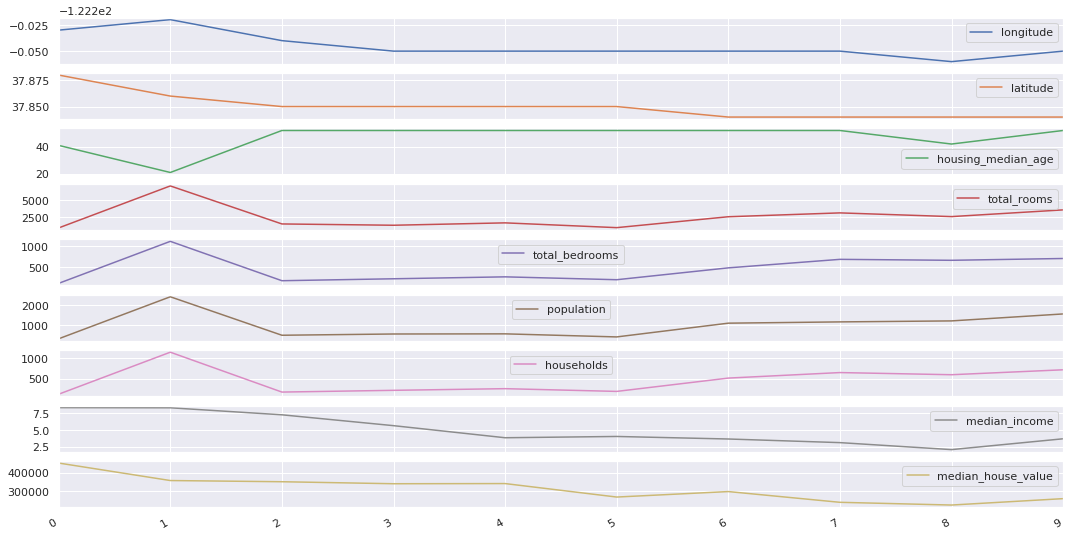

In [6]:
# plot first 10 samples
(train_df.head(10)).plot(subplots=True,figsize=(18,10))

In [7]:
X.head(),Y.head()

(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -122.23     37.88                41.0        880.0           129.0   
 1    -122.22     37.86                21.0       7099.0          1106.0   
 2    -122.24     37.85                52.0       1467.0           190.0   
 3    -122.25     37.85                52.0       1274.0           235.0   
 4    -122.25     37.85                52.0       1627.0           280.0   
 
    population  households  median_income  
 0       322.0       126.0         8.3252  
 1      2401.0      1138.0         8.3014  
 2       496.0       177.0         7.2574  
 3       558.0       219.0         5.6431  
 4       565.0       259.0         3.8462  , 0    452600.0
 1    358500.0
 2    352100.0
 3    341300.0
 4    342200.0
 Name: median_house_value, dtype: float64)

In [8]:
# scaling feature values using Z score normalization
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# splitting data into train and test
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=2003)

In [11]:
# reshaping data to match input dimension of network
train_x_np = train_x.reshape(train_x.shape[0],-1,train_x.shape[1])
test_x_np = test_x.reshape(test_x.shape[0],-1,test_x.shape[1])

train_y_np = train_y.to_numpy()
test_y_np = test_y.to_numpy()

In [12]:
train_x_np.shape

(14303, 1, 8)

In [13]:
class CnnRegressor(nn.Module):
    
    def __init__(self,in_ch,inputs,outputs,y_range):
        
        super(CnnRegressor,self).__init__()
        self.in_ch = in_ch
        self.inputs = inputs
        self.outputs =outputs
        self.y_range = y_range
        
        self.input_layer = nn.Conv1d(in_ch,50,3,padding=1)
        self.bactch_norm = nn.BatchNorm1d(50)
        self.con_layer = nn.Conv1d(50,100,3)
        self.con_layer2 = nn.Conv1d(100,150,3)
        self.con_layer3 = nn.Conv1d(150,200,4)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(200,100)
        self.batch_norm2 = nn.BatchNorm1d(100) 
        self.linear2 = nn.Linear(100,50)
        self.linear3 = nn.Linear(50,25)
        self.linear4 = nn.Linear(25,12)
        self.output_layer = nn.Linear(12,outputs)
        
    def forward(self,inp):
        
        inp =  inp
        x = F.relu(self.input_layer(inp))
        x = self.bactch_norm(x)
        x = F.relu(self.con_layer(x))
        x = F.relu(self.con_layer2(x))
        x = F.relu(self.con_layer3(x))
        
        x = self.flatten(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.batch_norm2(x)
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = torch.sigmoid(self.output_layer(x)) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]
        return x
    
    

In [14]:
from ignite.contrib.metrics.regression.r2_score import R2Score

In [15]:
#setting batch size and instiating model
batch_size = 1024
model = CnnRegressor(train_x_np.shape[1],train_x_np.shape[2],1,y_range = [min(train_y_np),max(train_y_np)*1.1])
model.cuda()
#model.load_state_dict(torch.load('117021_1dconv_reg'))

CnnRegressor(
  (input_layer): Conv1d(1, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (bactch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con_layer): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (con_layer2): Conv1d(100, 150, kernel_size=(3,), stride=(1,))
  (con_layer3): Conv1d(150, 200, kernel_size=(4,), stride=(1,))
  (flatten): Flatten()
  (linear1): Linear(in_features=200, out_features=100, bias=True)
  (batch_norm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=25, bias=True)
  (linear4): Linear(in_features=25, out_features=12, bias=True)
  (output_layer): Linear(in_features=12, out_features=1, bias=True)
)

In [16]:
# setting optimizer and hyper parameters
from torch.optim import lr_scheduler
optimizer = torch.optim.RMSprop(model.parameters(),lr=3e-4,weight_decay=3e-5,momentum=0.3);schedule=False
scheduler = lr_scheduler.MultiStepLR(optimizer,[10,25,40,60,75,],gamma=0.9);schedule=True



In [17]:
# traing and testing loop function
def model_loss(model,dataset,train=False,optimizer=None):
    
    if train==True:
        model.train()
        
    else:
        model.eval()
        
    performance = torch.nn.L1Loss()
    score_metric = R2Score()
    
    avg_loss = 0
    avg_score = 0
    count = 0
    
    for x,y in (dataset):
        
        pred = model(x)
        
        loss = performance(pred,y)
        score_metric.update([pred,y])
        score = score_metric.compute()
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if schedule:
                scheduler.step()
        
        avg_loss +=loss.item()
        avg_score+=score
        count+=1
        
    return avg_loss / count,score / count

In [18]:
epochs = 100

inputs = torch.from_numpy(train_x_np).cuda().float()
outputs = torch.from_numpy(train_y_np.reshape(-1,1)).cuda().float()

tensors = torch.utils.data.TensorDataset(inputs,outputs)
loader = torch.utils.data.DataLoader(tensors,batch_size,shuffle=True,drop_last=True)

In [19]:
# Training 
for ep in range(epochs):
    print('Epoch {0}/{1}'.format(ep,epochs))
    avg_loss,avg_r2 = model_loss(model,loader,train=True,optimizer=optimizer)
    
    print(" Loss:",avg_loss," R2:",avg_r2)

Epoch 0/100
 Loss: 71604.34585336539  R2: 0.026523894888498004
Epoch 1/100
 Loss: 44047.196213942305  R2: 0.05353930714386486
Epoch 2/100
 Loss: 39271.644230769234  R2: 0.05730210328300964
Epoch 3/100
 Loss: 38044.72716346154  R2: 0.058051174053844266
Epoch 4/100
 Loss: 36827.03846153846  R2: 0.05913070725977344
Epoch 5/100
 Loss: 36336.97205528846  R2: 0.05948996345457758
Epoch 6/100
 Loss: 35760.633713942305  R2: 0.05976255897126958
Epoch 7/100
 Loss: 35444.53064903846  R2: 0.059982523537906014
Epoch 8/100
 Loss: 35103.610877403844  R2: 0.060114653189054554
Epoch 9/100
 Loss: 35025.96018629808  R2: 0.06017659877069466
Epoch 10/100
 Loss: 34568.538161057695  R2: 0.060489527969033285
Epoch 11/100
 Loss: 34815.31640625  R2: 0.06039825565084797
Epoch 12/100
 Loss: 34166.328125  R2: 0.06079281736291437
Epoch 13/100
 Loss: 34044.01292067308  R2: 0.060938102146541336
Epoch 14/100
 Loss: 33813.55063100962  R2: 0.06100912916501365
Epoch 15/100
 Loss: 33634.854417067305  R2: 0.0611950833008836

In [20]:
# Testing

inputs = torch.from_numpy(test_x_np).cuda().float()
outputs = torch.from_numpy(test_y_np.reshape(-1,1)).cuda().float()

tensors = torch.utils.data.TensorDataset(inputs,outputs)
test_loader = torch.utils.data.DataLoader(tensors,1,shuffle=True,drop_last=True)

In [21]:

avg_loss,avg_r2 = model_loss(model,test_loader)
print(" Loss:",avg_loss," R2:",avg_r2)

 Loss: 34572.5300233228  R2: 0.00012614335478223178


In [23]:
torch.save(model.state_dict(),'1117021_1dconv_reg')